### Contents
[Model_training](#Model_training) <br>
Create a Mask R-CNN model and trains it with Pytorch lightning  <br>
[Visualize_one_prediction](#Visualize_one_prediction) <br>
Application of model on a specific image and visualize the results <br>
[Model_application_on_whole_test_site_with_performance_metric](#Model_application_on_whole_test_site_with_performance_metric) <br>
Application of the model on the whole test dataset.<br>
Visualizations of RTS characteristics possible.<br>
[Save_model_continue_raining](#Save_model_continue_raining) <br>
Continue training if model training was interupted


In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import sklearn.metrics as skmetrics
import torch
import os
import wandb
import torchmetrics
import warnings
import copy
import torchvision 
import random

from skimage.measure import regionprops
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, default_collate
from src.engine import analyze_preds, postprocess_iou, postprocess_slope, apply_watermask 
from src.dataset_module import DEMDataset
from src.emptyimg_dataset import emptyimg_Dataset
from src.model_module import Model
from src.visualizations import viz_bounding_box, vize_sample, viz_mask
from src.utils import move_images, split_train_test_mask, clean_raw_data, split_dataset_by_percentage,extract_shp
from src.config_model import get_config
from scipy.ndimage import gaussian_filter


if torch.cuda.is_available():
    print("GPU is available and configured correctly.")
else:
    print("No GPU available or GPU configuration is incorrect.")

/tmp/ipykernel_42408/1021500407.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


GPU is available and configured correctly.


In [2]:
# Set a fixed seed value
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

%load_ext autoreload
%autoreload 2

***
### Model_training
Back to [Contents](#Contents) <br>

In [3]:
# Get model configuration, some parameters combinations ar epreset in the src/config_model.py file

config_model = "final_model" # Three standard model: frozen_model, baseline, random_weights_model, final_model
scaled = False # True if min-max scaling should be used. False: z-score transformatin is used

if scaled:
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd_scaled.csv') #mean=0, std=1 to avoid z score transformation
else:    
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd.csv')
config, device, num_classes, worker_processes,gpu, gpu_device, threshold_mask, pretrained_network, transformed_data, change_min_box_axis = get_config(mean_sd, model = config_model)

if not len(config["channel_list"]) == config["n_channel"]:
    warnings.warn("Desired channels don't correspond to the number of channels")
if num_classes != 2:
    warnings.warn("Model predicts not just RTS")

In [4]:
# Get data path
name = "Sophia"
if scaled:    
    data_path  = f'data/{name}/data_clean/data_train/data_original_scaled'
    data_path_transformed = f'data/{name}/data_clean/data_train/data_original_plus_transformed_scaled'    
else:
    data_path = f'data/{name}/data_clean/data_train/data_original'
    data_path_transformed = f'data/{name}/data_clean/data_train/data_original_plus_transformed'
percentage = 0.8 #splitting into train & validation data

In [5]:
# Get data
if transformed_data: # Make sure that transformed image is in same group (train or val) as untransformed image to avoid information leakage
    print('transformed data is used')
    # Find number of train in original dataset
    img_name_org = [item for item in os.listdir(os.path.join(data_path, "images"))
                               if item.endswith(".tif")]
    n_train = int(len(img_name_org) * percentage)

    # get original train and val name (without .tif) with permutation
    train_name = random.sample(img_name_org, n_train)
    val_name =[item[:-4] for item in img_name_org if item not in train_name]

    # Get transformed data
    dataset_transformed = DEMDataset(data_path_transformed, config["n_channel"], config["channel_list"])
    transformed_name = [item for item in os.listdir(os.path.join(data_path_transformed, "images"))
                               if item.endswith(".tif")]
    
    # Find indices of validaiton data (so that transformed data is in same group as in not transformed)
    matching_indices = []

    for index_A, entry_val in enumerate(val_name):
        for index_transf, entry_transf in enumerate(transformed_name):
            if entry_val in entry_transf:
                matching_indices.append(index_transf)
    # Get indices of training data
    all_ind = list(range(len(transformed_name)))
    unmatched_ind = [num for num in all_ind if num not in matching_indices]         
    
    # split data
    train_set = torch.utils.data.Subset(dataset_transformed, matching_indices)
    val_set = torch.utils.data.Subset(dataset_transformed, unmatched_ind)
    print('N. training img', len(train_set), 'N. validation img', len(val_set), 'total:', len(dataset_transformed))
                   
else:
    dataset = DEMDataset(data_path, config["n_channel"], config["channel_list"])
    #test_set = DEMDataset(test_path, config["n_channel"], config["channel_list"])
    
    # Split the dataset in train and val set
    train_set, val_set = split_dataset_by_percentage(dataset, percentage, seed_value)
    print('N. training img:',len(train_set), 'N. validation img:', len(val_set),  'total:',len(dataset))

N. training img: 591 N. validation img: 148 total: 739


In [6]:
model = Model(
    num_classes, pretrained_network, config, change_min_box_axis)

In [7]:
# Define training and validation data loaders: Custome collate_fn makes list of batches. 
# batch consists of:
    # list (length = batch size) of image [c,h,w]
    # list (length = batch size) of dictionaries (= annotations including mask) where mask has size [c,h,w]
# This format is needed because library from torchvision expects a list of images/ targets. Default collate batches images to one single image size [b,c,h,w] and annotations to one single dictionary where matrixes such as mask have size [b,c,h,w]
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=config['batch_size'], shuffle=True, num_workers=worker_processes,
    collate_fn=lambda x: list(zip(*x))) # transforms from [(input_1, label_1), (input_2, label_2), ...] to [(input_1, input_2, ...)], [label_1, label_2, ...)]

val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=config['batch_size'], shuffle=False, num_workers=worker_processes,
    collate_fn=lambda x: list(zip(*x)))

#### Effective training starts here:

In [8]:
wandb.finish() # Clear previous results

# initialise the wandb logger 
wandb_logger = WandbLogger(project='working_on_code', name = "other_model_empty")
wandb_logger.experiment.config["batch_size"] = config['batch_size']

wandb: Currently logged in as: sophia-ly-16 (rts). Use `wandb login --relogin` to force relogin


In [9]:
# Track learning rate and model checkpoints 

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoint',
    filename='maskrcnn_{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True, # Whether callback will print information when a checkpoint is saved 
    monitor="sum_loss_validation",  # validation loss: 'val_loss', validation accuracy: "val_accuracy"
    mode='min',  # 'min' for val_loss, max for val_accuracy
    every_n_epochs=1,  # Save a checkpoint every x epochs
    every_n_train_steps=None,  # Save a checkpoint every N training steps (set to None to disable)
    train_time_interval=None  # Save a checkpoint after a certain time interval (set to None to disable)
)

# early stopping monitors a specified metric (e.g., validation loss) 
# Training is stopped if the metric does not improve for a certain number of epochs
early_stop_callback = EarlyStopping(
   monitor='sum_loss_validation',
   min_delta=0.00, # Minimum change in the monitored quantity to qualify as an improvement
   patience=5, # Number of epochs with no improvement after which training will be stopped
   verbose=1, # Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
   mode='min'
)

callbacks_trainer =[lr_monitor, checkpoint_callback] # , early_stop_callback]

In [10]:
if gpu:
    # Training with GPU Accelerator using 2 GPUs
    trainer = pl.Trainer(devices=gpu_device, accelerator="gpu", max_epochs=config["epochs"], deterministic=False,callbacks=callbacks_trainer,logger=wandb_logger )
else:
# CPU accelerator
    trainer = pl.Trainer(accelerator="cpu", max_epochs=config["epochs"], deterministic=True,callbacks=callbacks_trainer,logger=wandb_logger )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
wandb.finish()

In [22]:
if config['drop_out_apply']:
    model.eval()
    model.detector.roi_heads.box_head.fc7.weight = model.detector.roi_heads.box_head.fc7[0].weight
    model.detector.roi_heads.box_head.fc7.bias = model.detector.roi_heads.box_head.fc7[0].bias

In [23]:
# Save the model
file_path = 'model_name.pth'
torch.save(model.state_dict(), file_path)

***
### Visualize_one_prediction
Back to [Contents](#Contents) <br>


#### Application of model on specific images: Search for image and apply model

In [13]:
ask_for_input = False # Whether we want to be asked for each input or define it below

if not ask_for_input:
    config_model = "final_model" # Possible models: See utils/config_model.py, e.g. baseline, final_model
    scaled = False # True if min-max scaling should be used. False: z-score transformatin is used
    test_data = 'data_test'

else:
    print('What model do you want to use (has to match your saved model)? \033[1mAnswer: final_model, baseline, random_weights')
    config_model = input()
    print('How is the test ata folder called? Answer depends on your folders, \033[1me.g.: data_test, data_test_scaled, data_test_tuktoyaktuk')
    test_data = input()
    print('Do you want to apply z-transformation to the data? (min-max transformation is already applied on images called __scaled \033[1mAnswer 0 for no / 1 for yes')
    scaled  = not bool(int(input()))
    
    
if scaled:
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd_scaled.csv') #mean=0, std=1 to avoid z score transformation
else:    
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd.csv')
name ='Sophia'
test_path = f'data/{name}/data_clean/{test_data}'
slope_path = test_path+'/slope' 

test_set = DEMDataset(test_path, config["n_channel"], config["channel_list"])
config, device, num_classes, worker_processes,gpu, gpu_device, threshold_mask, pretrained_network, transformed_data, change_min_box_axis = get_config(mean_sd, model = config_model)

In [14]:
# Load the pretrained weights from the .pth file.
model = Model(
    num_classes, pretrained_network, config, change_min_box_axis)

model_path = "model/final_model_patience3.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [15]:
# Get dataloader that also can handle empty images
test_set = emptyimg_Dataset(test_path, config["n_channel"], config["channel_list"])
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0,
    collate_fn=lambda x: list(zip(*x)))

In [16]:
# Iterate through DataLoader until image is found
data_iter = iter(test_dataloader)
n_batch = len(data_iter) 

search = '2010-2016_tile_15_41_9_4_1_5.tif'
found_flag = False

for i in range(n_batch):
    print("batch", i)
    batch_test = next(data_iter)
    img_org, targ_org = batch_test
    
    for instance in range(len(targ_org)):
        if targ_org[instance]['tile'] == search:
            found_flag = True
            break  # Break out of the inner loop

    if found_flag:
        print('found')
        break  # Break out of the outer loop
print('batch:', i, 'img_id:', instance)

batch 0
batch 1
batch 2
found
batch: 2 img_id: 4


In [17]:
# Apply model on found batch
img_org, targ_org = batch_test
preds = model.forward(img_org)
preds_org = model.forward(img_org)

#### Visualize result

In [18]:
# Get img_id of wanted image from above print
id_viz = 4

In [21]:
# Create shapefile out of prediction: 
#Make sure a dictionary is created called 
folder_path = "/home/jovyan/work/master-thesis/prediction"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
# Name of .tif file: prediction_batch_i_id_viz_instance. Important if multiple predictions are ran, not so much in this case
RTS_ind= 0 
batch_i= 0
extract_shp(preds, targ_org, id_viz, os.getcwd(), RTS_ind, batch_i)

Folder '/home/jovyan/work/master-thesis/prediction' created.


2

Number of predicted RTS: 2 Number of labeled RTS: 2
Accuracy: 0.99, Precision: 0.91, Recall: 0.95, F1: 0.93, IoU: 0.87


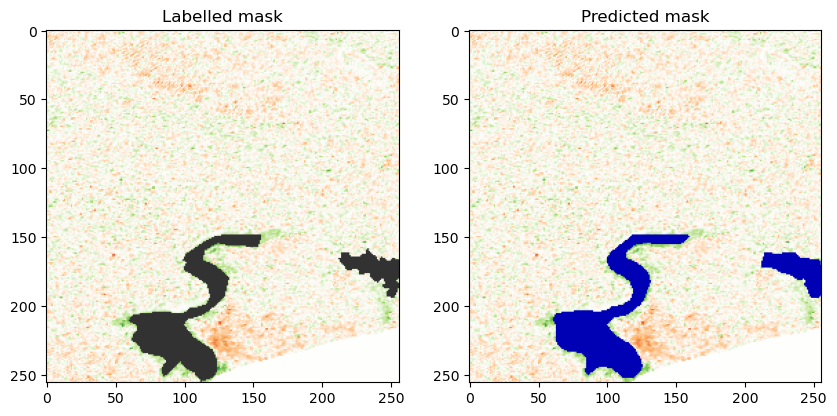

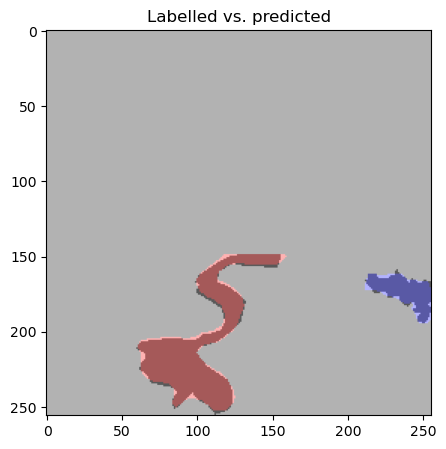

In [22]:
img_index = id_viz
viz_mask(img_org, targ_org, preds_org, img_index, background = False, viz_max = 3, viz_min = -3)

Number of predicted RTS: 2
Number of labelled RTS: 2
IoU: [0.9277986, 0.8071086], box 0
IoU: [0.9277986, 0.8071086], box 1


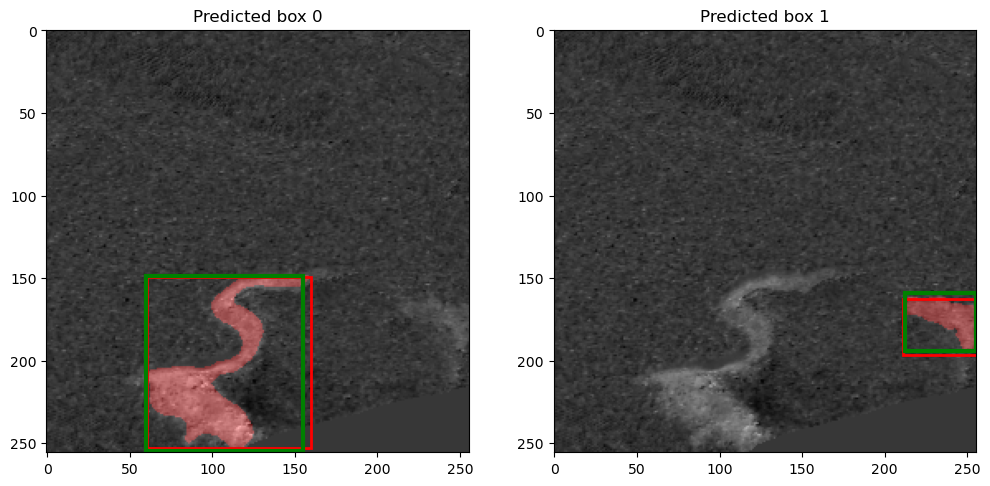

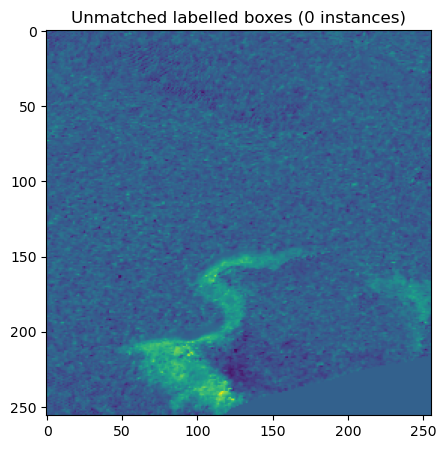

In [23]:
viz_bounding_box(batch_test, sample_index=img_index, threshold_mask=0.5, batch_pred = preds)

Number of detected objects = 2. Number of real objects = 2


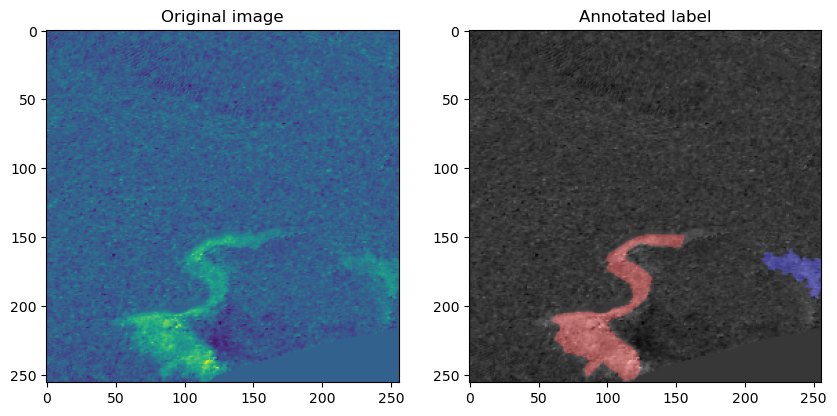

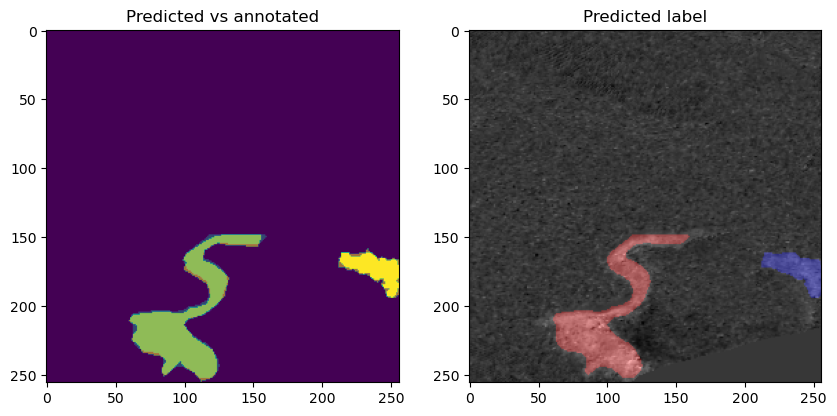

In [24]:
vize_sample(batch_test, id_viz, model_viz = None, threshold_mask = 0.5,predictions = preds)

### Model_application_on_whole_test_site_with_performance_metric
Back to [Contents](#Contents) <br>
Application of the model on the whole test dataset.<br>
Visualizations of RTS characteristics possible.<br>
Subchapter:<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Get_model_result](#Get_model_result): Number of FP on empty images, Summary of performance metrics  <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Visualize_RTS_characteristics](#Visualize_RTS_characteristics): Feature distribution comparing TP vs FP and TP vs labelled <br>



In [55]:
ask_for_input = False  # Whether we want to be asked for each input or define it below

if not ask_for_input:
    config_model = "final_model" # Possible models: See utils/config_model.py, e.g. baseline, final_model
    test_data = 'data_test'
    scaled = False # True if min-max scaling should be used. False: z-score transformatin is used
    get_RTS_info = True # Calculate RTS metric: mean_intensity_, sd_intensity_, pix_size_, circularity_, solidity_, max_diameter_
    postprocess_iou_apply = False # only keeps RTS detections if iou between mask and boundary box is > iou_min 
    postprocess_slope_apply = True # only keeps RTS detections that are not in high slopes (wher ehigh slope degree_thresh >= 25, if x fraction is on slope: iou threshold_onslope = 0.8)
    site_name = 'peel' # 'tukto'
    postprocess_watermask_apply = False # make sure site_name is correct
    create_shp = False # Whether shapefile should be generated from predictions


else:
    print('What model do you want to use (has to match your saved model)? \033[1mAnswer: final_model, baseline, random_weights')
    config_model = input()
    print('How is the test ata folder called? Answer depends on your folders, \033[1me.g.: data_test, data_test_scaled, data_test_tuktoyaktuk')
    test_data = input()
    print('Do you want to apply z-transformation to the data? (min-max transformation is already applied on images called __scaled \033[1mAnswer 0 for no / 1 for yes')
    scaled  = not bool(int(input())) # inverse boolean is needed
    print('Do you want to calculate RTS features (e.g. circularity ect.)? \033[1mAnswer 0 for no / 1 for yes')
    get_RTS_info = bool(int(input()))
    print('Do you want to apply post-processing based on \033[1m IoU \033[0m between RTS mask and bbox? \033[1mAnswer 1 for True / 0 for False')
    postprocess_iou_apply = bool(int(input()))
    print('Do you want to apply post-processing based on \033[1m slope\033[0m? \033[1mAnswer 1 for True / 0 for False')
    postprocess_slope_apply = bool(int(input()))
    print('Do you want to apply post-processing based on \033[1m water-mask\033[0m? \033[1mAnswer 1 for True / 0 for False')
    postprocess_watermask_apply = bool(int(input()))
    
    if postprocess_watermask_apply:
        print('What is your test site? \033[1mAnswer: peel, tukto')
        site_name = input()
    
    print('Do you want to transform predictions into shapefile and georef. tif? \033[1mAnswer 1 for True / 0 for False')
    create_shp = bool(int(input()))
    


if scaled:
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd_scaled.csv') #mean=0, std=1 to avoid z score transformation
else:    
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd.csv')
name ='Sophia'
test_path = f'data/{name}/data_clean/{test_data}'
slope_path = test_path+'/slope' 

 
config, device, num_classes, worker_processes,gpu, gpu_device, threshold_mask, pretrained_network, transformed_data, change_min_box_axis = get_config(mean_sd, model = config_model)

In [56]:
# Load the pretrained weights from the .pth file.
model = Model(
    num_classes, pretrained_network, config, change_min_box_axis)

model_path = "model/final_model_patience3.pth" #final_model_patience3_transformed3
checkpoint = torch.load(model_path)
''' # Only for models where this was deleted after training
if config['drop_out_apply']:
    del checkpoint['detector.roi_heads.box_head.fc7.0.weight']
    del checkpoint['detector.roi_heads.box_head.fc7.0.bias']'''
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [57]:
# Get dataloader that also can handle empty images
test_set = emptyimg_Dataset(test_path, config["n_channel"], config["channel_list"])
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0,
    collate_fn=lambda x: list(zip(*x)))

Apply model on whole dataset and calculate testing performance metrics:

In [ ]:
# thresholds that decide TP, TN
iou_thresholds = [0.5]

RTS_ind = 0 # RTS_id to keep track of number of predicted RTS (To later name the geotif)

# Set model to evaluation mode
model.eval()

# Performance metric and feature initialization-----------------
# RTS detection level
accuracy_ = []
precision_ = []
recall_ = []
F1_ = []
# loss
classificationloss_ = []
box_regressionloss_ = []
maskloss_ = []
iouRTS_ = []
# mask of detected RTS level
accuracy_pixel_ = []
precision_pixel_ = []
recall_pixel_ = []
F1_pixel_ = []
IoU_pixel_ = []
# RTS metric
accuracy_img_ = []
precision_img_ = []
recall_img_ = []
F1_img_ = []
IoU_img_ = []

# feature
mean_intensity = []
sd_intensity = []
pix_size = []
circularity = []
solidity = []
max_diameter = []
area = []
RTS_TP_id = []


with torch.no_grad(): # Apply model to whole dataset--------------------
    # iterate over batches
    for i, batch in enumerate(test_dataloader):
        print("Batch; ", i)
        img_org, targ_org = batch
        preds = model.forward(img_org)

        # Postprocess--------------------------------------------------
        if postprocess_iou_apply or postprocess_slope_apply:
            for img_i in range(len(preds)):
                if postprocess_iou_apply:
                    preds[img_i]["boxes"], preds[img_i]["labels"], preds[img_i]["scores"], preds[img_i]["masks"] = postprocess_iou(preds[img_i],  threshold_mask=0.5, iou_min = 0.25)
                if postprocess_slope_apply:
                    slope_tile = os.path.join(slope_path, targ_org[img_i]['tile'])
                    slope_img = gaussian_filter(np.array(Image.open(slope_tile)), sigma=15)
                    if np.mean(slope_img)> 60 and np.median(slope_img)>60:
                        preds[img_i]["boxes"], preds[img_i]["labels"], preds[img_i]["scores"], preds[img_i]["masks"] = postprocess_slope(preds[img_i], slope_img, degree_thresh = 30, threshold_mask=0.5, threshold_onslope = 0.8)
                if postprocess_watermask_apply:
                    preds[img_i]["boxes"], preds[img_i]["labels"], preds[img_i]["scores"], preds[img_i]["masks"] = apply_watermask(targ_org[img_i], preds[img_i], site_name, test_path)
        # Get shapefile
        if create_shp:
            for img_i in range(len(preds)):
                    RTS_ind = extract_shp(preds, targ_org, img_i, os.getcwd(), RTS_ind, i)

        # calculate performance metric-------------------------------
        if  get_RTS_info:
            batch_accuracy, batch_precision, batch_recall, batch_F1, classification_loss, box_regression_loss, mask_loss, iou_RTS, RTS_TP,accuracy_pixel, precision_pixel, recall_pixel, F1_pixel, IoU_pixel, accuracy_img, precision_img, recall_img, F1_img, IoU_img = model.test_step(img_org, targ_org, preds, iou_thresholds= iou_thresholds, get_TP_ind= get_RTS_info) 
            RTS_TP_id+= RTS_TP
        else:
            batch_accuracy, batch_precision, batch_recall, batch_F1, classification_loss, box_regression_loss, mask_loss, iou_RTS,accuracy_pixel, precision_pixel, recall_pixel, F1_pixel, IoU_pixel, accuracy_img, precision_img, recall_img, F1_img, IoU_img = model.test_step(img_org, targ_org, preds, iou_thresholds= iou_thresholds)

        # Collect the metrics for this batch
        # on RTS level
        accuracy_.append(batch_accuracy)
        precision_.append(batch_precision)
        recall_.append(batch_recall)
        F1_.append(batch_F1)
        # Loss
        classificationloss_.append(classification_loss)
        box_regressionloss_.append(box_regression_loss)
        maskloss_.append(mask_loss)
        iouRTS_.append(iou_RTS)
        # On mask per detected RTS level
        accuracy_pixel_.append(accuracy_pixel)
        precision_pixel_.append(precision_pixel)
        recall_pixel_.append(recall_pixel)
        F1_pixel_.append(F1_pixel)
        IoU_pixel_.append(IoU_pixel)

        # on binary image level
        accuracy_img_.append(accuracy_img)
        precision_img_.append(precision_img)
        recall_img_.append(recall_img)
        F1_img_.append(F1_img)
        IoU_img_.append(IoU_img)

        # Calculate RTS metric: mean_intensity_, sd_intensity_, pix_size_, circularity_, solidity_, max_diameter_ 
        if get_RTS_info:
            # iterate through tile/ batch
            for tile_id in range(len(preds)):
                mean_intensity_, sd_intensity_, pix_size_, circularity_, solidity_, max_diameter_, area_ = analyze_preds(preds, img_org, tile_id=tile_id, threshold_mask = 0.5)
                # Collect the metrics for this batch
                mean_intensity = mean_intensity + mean_intensity_
                sd_intensity = sd_intensity + sd_intensity_
                pix_size = pix_size + pix_size_
                circularity = circularity + circularity_
                solidity = solidity + solidity_
                max_diameter = max_diameter + max_diameter_
                area = area + area_
            
    print("Finished")
        

### Get_model_result
Back to the begining of the chapter: [Model_application_on_whole_test_site_with_performance_metric](#Model_application_on_whole_test_site_with_performance_metric) <br>

In [59]:
# Count number of FP on empty images.
count =0
for i in RTS_TP_id:
    if i==-2:
        count+=1
print('Number of FP RTS prediction on empty images = ', count)

Number of FP RTS prediction on empty images =  0


In [60]:
# Performance metric summary on RTS detetion level (1. evaluation level)
F1 = np.nanmean(F1_)
recall = np.nanmean(recall_)
precision = np.nanmean(precision_)
accuracy = np.nanmean(accuracy_)
iou = np.nanmean(iouRTS_)
# Loss
classificationloss = torch.nanmean(torch.stack(classificationloss_)) 
box_regressionloss = torch.nanmean(torch.stack(box_regressionloss_))
maskloss = torch.nanmean(torch.stack(maskloss_))
# on mask of detected RTS level
F1_pixel = np.nanmean(F1_pixel_)
recall_pixel = np.nanmean(recall_pixel_)
precision_pixel = np.nanmean(precision_pixel_)
accuracy_pixel = np.nanmean(accuracy_pixel_)
iou_pixel = np.nanmean(IoU_pixel_)
# on binary image level
F1_img = np.nanmean(F1_img_)
recall_img = np.nanmean(recall_img_)
precision_img = np.nanmean(precision_img_)
accuracy_img = np.nanmean(accuracy_img_)
iou_img = np.nanmean(IoU_img_)

In [61]:
RTS_metric = pd.DataFrame([{'RTS_F1': F1, 'RTS_recall': recall, 'RTS_precision': precision, 'RTS_accuracy': accuracy, 'bbox_iou': iou, 'classificationloss': classificationloss.item(), 'box_regressionloss': box_regressionloss.item(), 'maskloss':maskloss.item()}])
#df_metric.to_csv(f'{config_model}_performance.csv', index=False)
np.round(RTS_metric,2)


,RTS_F1,RTS_recall,RTS_precision,RTS_accuracy,bbox_iou,classificationloss,box_regressionloss,maskloss
0,0.84,0.78,0.86,0.73,0.64,1.26,8.15,0.69


In [62]:
# Summary of performance metric on second evaluation level (Based on the pixels of predictions per images transformed to a binary mask)
image_metric = pd.DataFrame([{'image_F1': F1_img, 'image_recall': recall_img, 'image_precision': precision_img, 'image_accuracy': accuracy_img, 'image_iou': iou_img}])
#df_metric.to_csv(f'{config_model}_performance.csv', index=False)
np.round(image_metric,2)

,image_F1,image_recall,image_precision,image_accuracy,image_iou
0,0.78,0.75,0.78,0.91,0.67


In [63]:
# Summary of performance metric on third evaluation level (Based on the pixels of RTS mask of only TP RTS detections)
mask_metric = pd.DataFrame([{'Mask_F1': F1_pixel, 'Mask_recall': recall_pixel, 'Mask_precision': precision_pixel, 'Mask_accuracy': accuracy_pixel, 'Mask_iou': iou_pixel}])
#df_metric.to_csv(f'{config_model}_performance.csv', index=False)
np.round(mask_metric,2)

,Mask_F1,Mask_recall,Mask_precision,Mask_accuracy,Mask_iou
0,0.83,0.87,0.82,1.0,0.72


In [64]:
# Get RTS features
circularity= [1 if entry > 1 else entry for entry in circularity] # Circularity is calculated based on RTS_perimeter. If it is too small, RTS falsely gets over 1, which is not possible
feature = pd.DataFrame({'mean_intensity': mean_intensity, 'sd_intensity': sd_intensity, 'pix_size': pix_size, 'max_diameter': max_diameter, 'circularity': circularity, 'solidity': solidity, 'label': RTS_TP_id})
#df_save.to_csv(f'{config_model}_RTS_metric.csv', index=False)

In [65]:
# Feature of TP RTS detections
df_TP = feature[feature["label"]==1]
np.round(df_TP.agg(['mean', 'median']),2)

,mean_intensity,sd_intensity,pix_size,max_diameter,circularity,solidity,label
mean,1.13,0.66,256.51,24.51,0.69,0.84,1.0
median,1.01,0.62,154.00,19.85,0.70,0.87,1.0


In [66]:
# Features of FP RTS detections
df_FP = feature[feature["label"]==-1]
np.round(df_FP.agg(['mean', 'median']),2)

,mean_intensity,sd_intensity,pix_size,max_diameter,circularity,solidity,label
mean,1.02,0.63,131.81,18.45,0.73,0.87,-1.0
median,0.84,0.63,96.00,15.30,0.78,0.89,-1.0


### Visualize_RTS_characteristics
Back to the begining of the chapter: [Model_application_on_whole_test_site_with_performance_metric](#Model_application_on_whole_test_site_with_performance_metric) <br>

##### TP vs. FP ---------------------------------------------------------

In [67]:
print('Features that can be visualized: ')
print(feature.columns)

Features that can be visualized: 
Index(['mean_intensity', 'sd_intensity', 'pix_size', 'max_diameter',
       'circularity', 'solidity', 'label'],
      dtype='object')


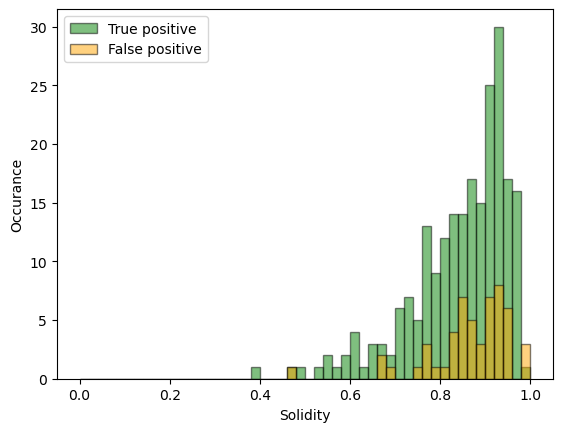

In [68]:
# Visualization of x feauture
x = 'solidity'
x_title = 'Solidity'
binwidth = 0.02 # Adjust binwidth depending on the data

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(df_FP[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(df_FP[x]))), int(np.floor(max(df_TP[x]))))
plt.hist(df_TP[x], color='green', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth), edgecolor='black')
plt.hist(df_FP[x], color='orange', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['True positive', 'False positive'])
#plt.xlim(0.5, )
#plt.title(f'{config_model}')
#plt.savefig(f'{config_model}_{x}_tukto.png')
plt.show()


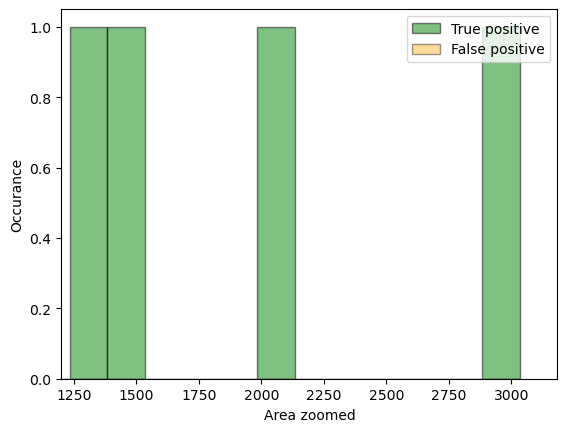

In [69]:
# Visualization of x zoomed in feauture TP predicted vs labelled
x = 'pix_size'
x_title = 'Area zoomed'
binwidth = 150

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(df_TP[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(df_FP[x]))), int(np.floor(max(df_TP[x]))))

plt.hist(df_TP[df_TP[x]>1250][x], color='green', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
plt.hist(df_FP[df_FP[x]>1250][x], color='orange', alpha=0.4, bins= np.arange(x_min, x_max+ binwidth, binwidth), edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['True positive', 'False positive'])
plt.xlim(1200,)
#plt.title(f'{config_model}')
#plt.savefig(f'{config_model}_{x}_tukto_zoomed.png')
plt.show()


#### TP vs. labelled RTS---------------------------------------------------------

In [70]:
# Calculate labelled RTS features from test images

mean_intensity_ = []
sd_intensity_  = []
pix_size_ = []
circularity_ = []
solidity_ = []
max_diameter_ = []
area_ = []

tile_names = os.listdir(test_path + '/masks')
for tile in tile_names:
    if tile.endswith('.tif'):
        imge_mask = np.array(Image.open(test_path + f'/masks/{tile}'))
        image_height = np.array(Image.open(test_path + f'/images/{tile}'))

        n_instances = len(np.unique(imge_mask))-1
        for i in range(1, n_instances+1):
            instance_val = np.unique(imge_mask)[i]
            # Make mask binary
            mask_boolean = (imge_mask == instance_val).astype(int)
            # Calculate values from intensity image
            mean_intensity = np.nanmean(image_height[mask_boolean>0])
            sd_intensity = np.std(image_height[mask_boolean>0])
            # Calculate values based on shape

            mask_prop = regionprops(mask_boolean)[0] # We only have one instance per binary mask
            pix_size = np.count_nonzero(mask_boolean)
            RTS_perimeter = mask_prop.perimeter
            if RTS_perimeter ==0: # regionprop cannot handle very small objects->approximate perimeter
                RTS_perimeter = mask_prop.feret_diameter_max *2
            circularity = (4*np.pi*pix_size)/(RTS_perimeter**2)
            if circularity>1:
                circularity = 1
            solidity = mask_prop.solidity
            max_diameter = mask_prop.feret_diameter_max
            area = mask_prop.area
            # Append values
            mean_intensity_.append(mean_intensity)
            sd_intensity_.append(sd_intensity)
            pix_size_.append(pix_size)
            circularity_.append(circularity)
            solidity_.append(solidity)
            max_diameter_.append(max_diameter)
            area_.append(area)

In [71]:
# RTS features of labelled RTSs
img_feature = pd.DataFrame({'mean_intensity': mean_intensity_, 'sd_intensity': sd_intensity_, 'area': area_, 'pix_size': pix_size_,  'max_diameter': max_diameter_,'circularity': circularity_, 'solidity': solidity_})
#df_save.to_csv(f'{config_model}_RTS_metric.csv', index=False)
np.round(img_feature.agg(['mean', 'median']),2)

,mean_intensity,sd_intensity,area,pix_size,max_diameter,circularity,solidity
mean,1.16,0.55,216.87,216.87,23.43,0.62,0.80
median,1.06,0.50,131.50,131.50,19.36,0.59,0.82


In [72]:
print('Features that can be visualized: ')
print(feature.columns)

Features that can be visualized: 
Index(['mean_intensity', 'sd_intensity', 'pix_size', 'max_diameter',
       'circularity', 'solidity', 'label'],
      dtype='object')


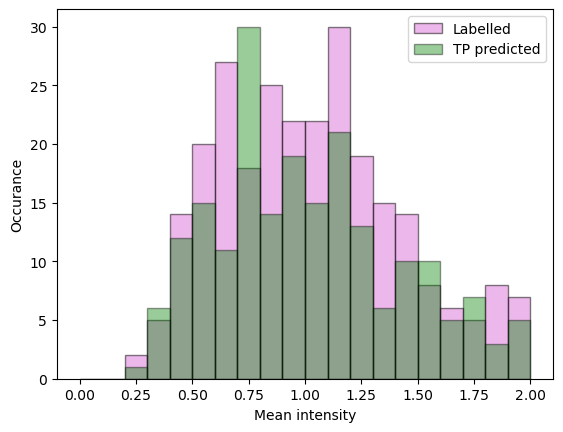

In [73]:
# Visualization of x feauture TP predicted vs labelled
x = 'mean_intensity'
x_title = 'Mean intensity'
binwidth = 0.1 # adapt depending on feature

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(img_feature[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(img_feature[x]))), int(np.floor(max(df_TP[x]))))
plt.hist(img_feature[x], color='orchid', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
plt.hist(df_TP[x], color='green', alpha=0.4, bins= np.arange(x_min, x_max+ binwidth, binwidth), edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['Labelled', 'TP predicted'])
#plt.xlim(0.2, 1)
#plt.title(f'{config_model}')
#plt.savefig(f'{config_model}_{x}_labelled_tukto.png')
plt.show()


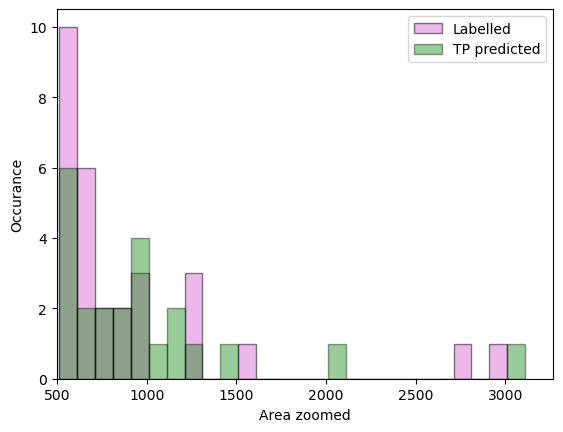

In [74]:
# Visualization of x feauture TP predicted vs labelled
x = 'pix_size'
x_title = 'Area zoomed'
binwidth = 100

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(img_feature[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(img_feature[x]))), int(np.floor(max(df_TP[x]))))
plt.hist(img_feature[img_feature[x]>500][x], color='orchid', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
plt.hist(df_TP[df_TP[x]>500][x], color='green', alpha=0.4, bins= np.arange(x_min, x_max+ binwidth, binwidth), edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['Labelled', 'TP predicted'])
plt.xlim(500, )
#plt.title(f'{config_model}')
#plt.savefig(f'{config_model}_{x}_labelled_tukto_zoomed.png')
plt.show()


***
### Save_model_continue_raining 
Back to [Contents](#Contents) <br>

In [ ]:
# Load the best checkpoint
checkpoint_path = 'checkpoint'
check_point_p = sorted(f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f)))
check_point_f = torch.load(os.path.join(checkpoint_path, check_point_p[-1]))

In [ ]:
# Load weights of saved model into new model
model_new = Model(num_classes, pretrained_network) # num_classes = 2
model_new.load_state_dict(check_point_f["state_dict"])

### Continuing training

In [ ]:
wandb.finish()

In [ ]:
# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='RTS_smalldataset_retrain')

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = config['batch_size']

In [ ]:
# Track learning rate and model checkpoints 

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoint',
    filename='maskrcnn_{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True, # Whether callback will print information when a checkpoint is saved 
    monitor="validation_accuracy",  # validation loss: 'val_loss', validation accuracy: "val_accuracy"
    mode='max',  # 'min' for val_loss, max for val_accuracy
    every_n_epochs=1,  # Save a checkpoint every x epochs
    every_n_train_steps=None,  # Save a checkpoint every N training steps (set to None to disable)
    train_time_interval=None  # Save a checkpoint after a certain time interval (set to None to disable)
)


callbacks_trainer =[lr_monitor, checkpoint_callback]

In [ ]:
if gpu:
    # Training with GPU Accelerator using 2 GPUs
    trainer = pl.Trainer(devices=gpu_device, accelerator="gpu", max_epochs=config["epochs"], deterministic=False,callbacks=callbacks_trainer,logger=wandb_logger )
else:
# CPU accelerator
    trainer = pl.Trainer(accelerator="cpu", max_epochs=config["epochs"], deterministic=True,callbacks=callbacks_trainer,logger=wandb_logger )

In [ ]:
# Continue training
trainer.fit(model_new, train_dataloader, val_dataloader)

In [ ]:
wandb.finish()

***
#### Hyperparameter sweep

In [ ]:
# TODO: Finish once overfitting is done

In [ ]:
wandb.finish()
wandb.login()

In [ ]:
# Track learning rate and model checkpoints 

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoint',
    filename='maskrcnn_{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True, # Whether callback will print information when a checkpoint is saved 
    monitor="validation_accuracy",  # validation loss: 'val_loss', validation accuracy: "val_accuracy"
    mode='max',  # 'min' for val_loss, max for val_accuracy
    every_n_epochs=1,  # Save a checkpoint every x epochs
    every_n_train_steps=None,  # Save a checkpoint every N training steps (set to None to disable)
    train_time_interval=None  # Save a checkpoint after a certain time interval (set to None to disable)
)


callbacks_trainer =[lr_monitor, checkpoint_callback]

In [ ]:
# First try
# other possible config: dropout
# TODO: check early_terminate
sweep_config = {
    "method": "random", # grid, random, bayes
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "val_acc"}, #minimize loss, maximize val_acc
    "parameters": {
        "optimizer": {"values": ['sgd']}, # TODO: once adam is implemented,"optimizer": {"values": ['adam', 'sgd']},
        "batch_size": {"values": [1, 2]}, #"batch_size": {'distribution': 'q_log_uniform_values', "values": [1, 10]},
        "epochs": {"values": [1, 3]},
        "lr": {'distribution': 'uniform', "max": 0.1, "min": 0.0001},
    },
}

sweep_id = wandb.sweep(sweep_config, project="RTS_sweep")

# Define a function to train your model
def sweep_iteration():
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger = WandbLogger()
    
    # Create and train your model using the specified hyperparameters
    model_sweep = Model(num_classes, lr=wandb.config.lr)


    train_dataloader_sweep = torch.utils.data.DataLoader(
    train_set, batch_size=wandb.config.batch_size, shuffle=True, num_workers=worker_processes,
    collate_fn=lambda x: tuple(zip(*x)))

    val_dataloader_sweep = torch.utils.data.DataLoader(
    val_set, batch_size=wandb.config.batch_size, shuffle=False, num_workers=worker_processes,
    collate_fn=lambda x: tuple(zip(*x)))

    trainer = pl.Trainer(accelerator="cpu", max_epochs=wandb.config.epochs, deterministic=False,callbacks=callbacks_trainer, logger=wandb_logger)
    
    # Train the model using your training and validation data
    trainer.fit(model_sweep, train_dataloader_sweep, val_dataloader_sweep)
    
    # Log metrics
    # Retrieve and log the "loss_IoU similarity" from the final training step
    last_training_step_output = trainer.callback_metrics
    loss_IoU similarity = last_training_step_output["loss_IoU similarity"]

    wandb.log({"loss_IoU similarity": loss_IoU similarity})

# Initialize the sweep and start it
if sweep_config['method'] == 'random':
    wandb.agent(sweep_id, function=sweep_iteration, count=3) # Count = number of sweeps if random
else:
    wandb.agent(sweep_id, function=sweep_iteration) # gridsearch goes through all parameters

In [ ]:
# TODO Access data
loss_IoU similarity_values = logged_metrics["loss_IoU similarity"]

# Sample dictionary of hyperparameters and their corresponding validation losses
hyperparameters_and_metrics = {
    "loss": loss_IoU similarity_values,
    "batch_size": [32, 64, 128]
}

# Assume you want to minimize validation loss. TODO: change
best_hyperparameters = min(hyperparameters_and_metrics, key=hyperparameters_and_metrics.get)

# Extract the best configuration
best_learning_rate = best_hyperparameters["learning_rate"]
best_batch_size = best_hyperparameters["batch_size"]

***
### Helper functionto explore backbone architecture

In [47]:
# Recursive search to find model path
def go_deeper(getattr_, attribute_to_search, path, dict_previous = []):
    '''
    Searches for attribute_to_search in a recursive way. Goes into each branch of the model architecture until it reaches the deepest point. 
    Go further up until a new branch is found. 
    Input:
        attribute_to_search: string. We search for a node that contains this string
        path: in the begining an empty list, will be filled through recursive search. ... means we go into a deeper branch.
        _finished_directory: We have gone through the whole dictionary on one level of the model
    Return:
        Dictionary: all model architecture nodes found during the search of the attribute.
    '''
    dictionary = dir(getattr_)
    
    if dict_previous == dictionary:
        path.append('_breakloop')
        return dictionary
    
    elif any(attribute_to_search in s for s in dictionary):
        found_attribute = [entry for entry in dictionary if attribute_to_search in entry]
        print(f'found: {found_attribute}')
        #print(getattr_)
        print(dictionary)
        
        
    if type(dictionary) == list:
        for entry in dictionary:
            attribute = str(entry)
            if attribute in path:
                continue
            elif not attribute.startswith('__') and not attribute.startswith('_') and attribute != 'H' and attribute != 'T' and attribute != 'mH' and attribute != 'mT':
                path.append(attribute)
                #print(attribute)
                path.append('...') # Goes deeper 
                go_deeper(getattr(getattr_, attribute), attribute_to_search, path, dictionary)
        path.append('_finished_directory')
                
    else:  
        path.append('_')
        #print('return')
        return dictionary
        

In [48]:
path = []
search_for = 'batch'
test = go_deeper(getattr(model, 'detector'), search_for, path)
test

found: ['batch_size_per_image']
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_size_per_image', 'positive_fraction']
found: ['_onnx_batch_images', 'batch_images']
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_

Search the direct path to the target

In [49]:
id_search = path.index('box_predictor')
id_search

2270

In [167]:
# Split list at '_finished_directory' and only keep those that where not finished
my_list = path[:id_search+1]

# Initialize a list to store sublists
result = []
sublist = []

# Iterate through the elements of the list
for item in my_list:
    if item == '_finished_directory':
        # If ':' is encountered, append the current sublist to the result list
        result.append(sublist)
        # Reset the sublist for the next group
        sublist = []
    else:
        # Add the item to the current sublist
        sublist.append(item)

# Append the last sublist if the list ends with an element other than ':'
if sublist:
    result.append(sublist)

In [168]:
finished = []
i_remove = []
i_loop_end = []
for i, element in enumerate(result):
    if len(element) <1: # empty: means that higher hiarchical loop is finished
        i_loop_end.append(i)
        i_remove.append(i)
    elif element[-1].endswith('...'): 
        if len(element)>=3:
            finished.append(element[-2]) # add finished directory
            result[i] = element[:-2]
        else:  # only entry is finished directory-> remove
            finished.append(element[0])
            i_remove.append(i)
    elif element[-1] == '_breakloop':
        i_remove.append(i)
                              

In [169]:
# Check how many hiarchies are closed
adjacent_indices = []

for i in range(len(i_loop_end) - 1):
    if i_loop_end[i + 1] - i_loop_end[i] == 1:
        adjacent_indices.append((i_loop_end[i], i_loop_end[i + 1]))

print("Adjacent indices:", adjacent_indices)

Adjacent indices: [(193, 194), (728, 729), (735, 736)]


In [170]:
last_closed_loop = adjacent_indices[-1][-1]
last_closed_loop

736

In [171]:
adapted_remove = list(np.array(i_remove) - last_closed_loop)
unclosed = result[last_closed_loop:]


In [172]:
filtered_list_ = [element for index, element in enumerate(unclosed) if index not in adapted_remove]

In [173]:
filtered_list_

[['roi_heads', '...'],
 ['box_coder', '...'],
 ['box_head', '...', 'fc6', '...'],
 ['box_predictor']]

In [732]:
print(model.detector.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


In [710]:
print(model.detector.rpn._post_nms_top_n)

{'training': 2000, 'testing': 1000}


In [565]:
print(model.detector.roi_heads.nms_thresh)

0.5


In [21]:
model.detector.roi_heads.detections_per_img

100

In [29]:
print(model.detector.roi_heads)

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (mask_head): MaskRCNNHeads(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(

In [51]:
# Delete folders to clean up
import shutil
shutil.rmtree('checkpoint')